In [5]:
import os

ROOT_DATA = os.environ.get('LARD_DATA_ROOT_PATH')
ROOT_PROJECT = os.environ.get('LARD_PROJECT_ROOT_PATH')

print(ROOT_DATA)
print(ROOT_PROJECT)


/fileonssd/runway-dataset/lard-dataset
/home/yeli/workspace/lard/lard-detection


# 统计不同距离/时间的图片数量

In [6]:
import pandas as pd
import numpy as np


def get_num_vs_dist(path_info):
    df = pd.read_csv(path_info, sep=';')
    type = 'real' if 'real' in path_info else 'synth'

    bins_synth = [0, 0.5, 1, 1.5, 2, 2.5, 3]
    bins_real = [0, 10, 20, 40, 80, 160]

    if type == 'synth':
        bins = bins_synth
        key_col = 'along_track_distance'
        index_name = 'Along track distance'
    elif type == 'real':
        bins = bins_real
        key_col = 'time_to_landing'
        index_name = 'Time to landing'
    else:
        print('Error')
        
    df['group'] = pd.cut(df[key_col], bins=bins, labels=False)
    df_group = df.groupby('group')

    all_len = []
    for group_id in range(len(bins)-1):
        file_list = df_group.get_group(group_id).image.apply(lambda x: os.path.basename(x)).to_list()
        all_len.append(len(file_list))

    col = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
    df = pd.DataFrame(all_len, index=col, columns=['Number of images'])
    df.index.name = index_name
    return df

path_synth = f'{ROOT_DATA}/LARD_dataset_decompressed/LARD_test/LARD_test_synth/LARD_test_synth.csv'
path_real_nominal = f'{ROOT_DATA}/LARD_dataset_decompressed/LARD_test/LARD_test_real/LARD_test_real_nominal_cases/LARD_test_real_nominal_cases.csv'
path_real_edge = f'{ROOT_DATA}/LARD_dataset_decompressed/LARD_test/LARD_test_real/LARD_test_real_edge_cases/LARD_test_real_edge_cases.csv'
path_real = f'{ROOT_PROJECT}/results/tables/info/LARD_test_real.csv'

df_synth = get_num_vs_dist(path_synth)
df_real_nominal = get_num_vs_dist(path_real_nominal)
df_real_edge = get_num_vs_dist(path_real_edge)
df_real = get_num_vs_dist(path_real)

df_synth.columns = ['synth']
df_real = pd.concat([df_real_nominal, df_real_edge, df_real], axis=1)
df_real.columns = ['real_nominal', 'real_edge', 'real']
display(df_synth)
display(df_real)

,synth
Along track distance,
0-0.5,558
0.5-1,453
1-1.5,418
1.5-2,341
2-2.5,273
2.5-3,169


,real_nominal,real_edge,real
Time to landing,,,
0-10,417,124,541
10-20,447,91,538
20-40,369,58,427
40-80,213,31,244
80-160,53,6,59


# TIDE

In [7]:
from tidecv import TIDE, Data
import json
import numpy as np
import pandas as pd
from tqdm import tqdm

def get_main_error(path_prediction_json):
    all_main_error = []
    all_special_error = []
    for dataset in tqdm(['test_synth', 'test_real_nominal', 'test_real_edge', 'test_real']):

        cocoGtFile = f'{ROOT_PROJECT}/datasets/lard/annotations/instances_{dataset}.json'
        cocoDtFile = f'{path_prediction_json}/test/{dataset}/predictions_modified.json'

        with open(cocoGtFile) as f:
            gt_json = json.load(f)

        with open(cocoDtFile) as f:
            dets_json = json.load(f)

        tide = TIDE()

        gt_data = Data('gt_data')
        det_data = Data('det_data')

        for det in gt_json['annotations']:
            image = det['image_id']
            _cls = det['category_id']
            box = det['bbox'] if 'bbox' in det else None
            mask = det['segmentation'] if 'segmentation' in det else None
            gt_data.add_ground_truth(image, _cls, box, mask)

        for det in dets_json:
            image = det['image_id']
            _cls = det['category_id']
            score = det['score']
            box = det['bbox'] if 'bbox' in det else None
            mask = det['segmentation'] if 'segmentation' in det else None
            det_data.add_detection(image, _cls, score, box, mask)

        tide.evaluate(gt_data, det_data, mode=TIDE.BOX)
        # tide.summarize()
        # tide.plot()
    
        main_error = tide.get_main_errors()['det_data']
        df = pd.DataFrame(list(main_error.items()), columns=['Error Type', dataset]).round(3)
        df = df.set_index('Error Type')
        all_main_error.append(df)

        special_error = tide.get_special_errors()['det_data']
        df = pd.DataFrame(list(special_error.items()), columns=['Error Type', dataset]).round(3)
        df = df.set_index('Error Type')
        all_special_error.append(df)
        
    all_main_error = pd.concat(all_main_error, axis=1)
    all_special_error = pd.concat(all_special_error, axis=1)
    return all_main_error, all_special_error

base_model_name = 'base/yolov8n_640'
proposed_model_name = 'merge/yolov8n_lska_bifpn_EIoU_aug_all_5_640'
df1, df1_ = get_main_error(f'{ROOT_PROJECT}/runs/ultralytics/{base_model_name}')
df2, df2_ = get_main_error(f'{ROOT_PROJECT}/runs/ultralytics/{proposed_model_name}')

display(df1)
display(df2)

100%|██████████| 4/4 [00:02<00:00,  1.97it/s]


,test_synth,test_real_nominal,test_real_edge,test_real
Error Type,,,,
Cls,0.000,0.000,0.000,0.000
Loc,2.192,5.598,9.385,6.291
Both,0.000,0.000,0.000,0.000
Dupe,0.004,0.004,0.031,0.008
Bkg,0.023,1.021,2.097,1.130
Miss,0.941,7.069,20.359,9.747


,test_synth,test_real_nominal,test_real_edge,test_real
Error Type,,,,
Cls,0.000,0.000,0.000,0.000
Loc,1.498,1.222,4.776,1.887
Both,0.000,0.000,0.000,0.000
Dupe,0.225,0.196,0.129,0.193
Bkg,0.240,1.139,4.687,2.025
Miss,1.186,1.026,3.737,1.554


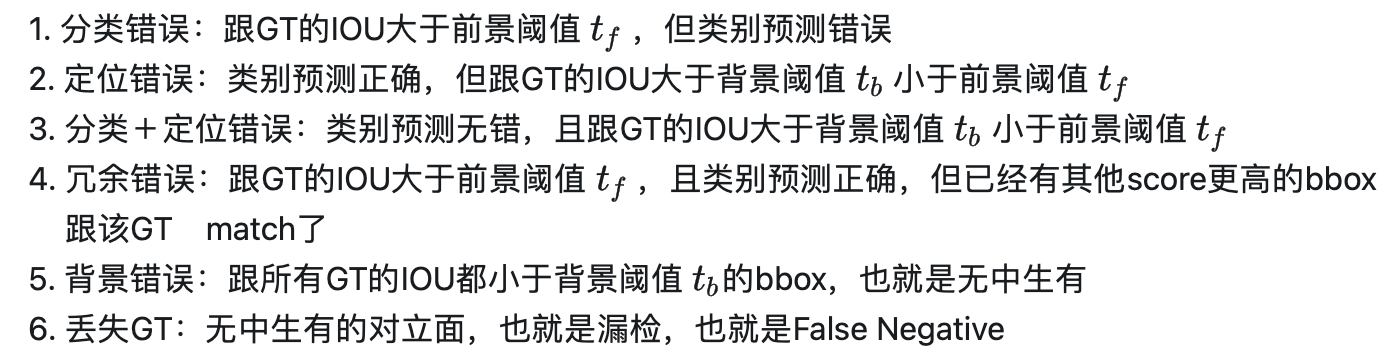

# MAP分组分析

In [8]:
# 合并nominal edge数据集信息csv
path_real_nominal = f'{ROOT_DATA}/LARD_dataset_decompressed/LARD_test/LARD_test_real/LARD_test_real_nominal_cases/LARD_test_real_nominal_cases.csv'
df_nominal = pd.read_csv(path_real_nominal, sep=';')
path_real_edge = f'{ROOT_DATA}/LARD_dataset_decompressed/LARD_test/LARD_test_real/LARD_test_real_edge_cases/LARD_test_real_edge_cases.csv'
df_edge = pd.read_csv(path_real_edge, sep=';')

df_real = pd.concat([df_nominal, df_edge])
df_real.to_csv(f'{ROOT_PROJECT}/results/tables/info/LARD_test_real.csv', index=False, sep=';')
print(df_nominal.shape, df_edge.shape)
print(df_real.shape)

(1500, 29) (311, 29)
(1811, 29)


In [9]:
import json
import shutil
import sys
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import scienceplots
from IPython.display import clear_output
sys.path.append('/home/yeli/workspace/lard/lard-detection/')
from src.utils.metric import coco_metrics_name
from src.utils.metric import cal_coco_metrics


plt.style.use('science')
plt.rcParams['text.usetex'] = False

bins_synth = [0, 0.5, 1, 1.5, 2, 2.5, 3]
bins_real = [0, 10, 20, 40, 80, 160]

def cal_coco_metrics_grouped(type, path_info, path_anno, path_pred):

    # 存储临时json文件
    temp_folder = './grouped_json'
    os.makedirs(temp_folder, exist_ok=True)
    
    df = pd.read_csv(path_info, sep=';')

    if type == 'synth':
        bins = bins_synth
        key_col = 'along_track_distance'
        index_name = 'Along track distance'
        unit_name = 'nm'
    elif type == 'real':
        bins = bins_real
        key_col = 'time_to_landing'
        index_name = 'Time to landing'
        unit_name = 's'
    else:
        print('Error')
        
    coco_true = COCO(annotation_file=path_anno)

    # 使用pd.cut()函数对数据框进行分组
    df['group'] = pd.cut(df[key_col], bins=bins, labels=False)
    # 分组
    df_group = df.groupby('group')

    # 各组metrics
    all_metrics = {}

    for group_id in range(len(bins)-1):

        # 获取本足图像文件名列表
        file_list = df_group.get_group(group_id).image.apply(lambda x: os.path.basename(x)).to_list()

        # 取真值
        # 筛选图像
        imgs_to_keep = []
        anns_to_keep = []

        for img in coco_true.imgs.values():
            if img['file_name'] in file_list:
                imgs_to_keep.append(img)
                ann_ids = coco_true.getAnnIds(imgIds=img['id'])
                anns_to_keep.extend(coco_true.loadAnns(ann_ids))

        # 构建新的JSON数据
        group_instances_data = {
            "images": imgs_to_keep,
            "annotations": anns_to_keep,
            "categories": coco_true.loadCats(coco_true.getCatIds())
        }

        # 保存为分组后的JSON文件
        if type == 'synth':
            group_instances_file = f'{temp_folder}/instances_test_synth_dist{group_id}.json'
        elif type == 'real':
            group_instances_file = f'{temp_folder}/instances_test_synth_time{group_id}.json'
        else:
            print('Error')
        with open(group_instances_file, 'w') as f:
            json.dump(group_instances_data, f, indent=4)

        # 取预测
        # GT对应的图像id
        image_id_to_keep = [ann['image_id'] for ann in anns_to_keep]
        
        with open(path_pred, 'r') as file:
            data = json.load(file)

        # 构建新的JSON数据
        group_predictions_data = [pred for pred in data if pred['image_id'] in image_id_to_keep]

        # 保存为分组后的JSON文件
        group_predictions_file = f'{temp_folder}/predictions_test_synth_dist{group_id}.json'
        with open(group_predictions_file, 'w') as f:
            json.dump(group_predictions_data, f, indent=4)

        # 算误差
        coco_evaluator = cal_coco_metrics(group_instances_file, group_predictions_file)

        # 构建df
        all_metrics[f"{bins[group_id]}-{bins[group_id+1]}"] = coco_evaluator.stats

    all_metrics = pd.DataFrame(all_metrics, index=coco_metrics_name)
    all_metrics.index.name = index_name
    shutil.rmtree(temp_folder)

    return all_metrics


def get_metrics(model_name):

    # Synth
    path_synth = f'{ROOT_DATA}/LARD_dataset_decompressed/LARD_test/LARD_test_synth/LARD_test_synth.csv'
    path_anno = f'{ROOT_PROJECT}/datasets/lard/annotations/instances_test_synth.json'
    path_pred = f'{ROOT_PROJECT}/runs/ultralytics/{model_name}/test/test_synth/predictions_modified.json'
    metrics_synth = cal_coco_metrics_grouped('synth', path_synth, path_anno, path_pred)

    # Real nominal cases
    path_real_nominal = f'{ROOT_DATA}/LARD_dataset_decompressed/LARD_test/LARD_test_real/LARD_test_real_nominal_cases/LARD_test_real_nominal_cases.csv'
    path_anno = f'{ROOT_PROJECT}/datasets/lard/annotations/instances_test_real_nominal.json'
    path_pred = f'{ROOT_PROJECT}/runs/ultralytics/{model_name}/test/test_real_nominal/predictions_modified.json'
    metrics_nominal = cal_coco_metrics_grouped('real', path_real_nominal, path_anno, path_pred)

    # Real edge cases
    path_real_edge = f'{ROOT_DATA}/LARD_dataset_decompressed/LARD_test/LARD_test_real/LARD_test_real_edge_cases/LARD_test_real_edge_cases.csv'
    path_anno = f'{ROOT_PROJECT}/datasets/lard/annotations/instances_test_real_edge.json'
    path_pred = f'{ROOT_PROJECT}/runs/ultralytics/{model_name}/test/test_real_edge/predictions_modified.json'
    metrics_edge = cal_coco_metrics_grouped('real', path_real_edge, path_anno, path_pred)

    # Real cases
    path_real = f'{ROOT_PROJECT}/results/tables/info/LARD_test_real.csv'  # 拼接数据
    path_anno = f'{ROOT_PROJECT}/datasets/lard/annotations/instances_test_real.json'
    path_pred = f'{ROOT_PROJECT}/runs/ultralytics/{model_name}/test/test_real/predictions_modified.json'
    metrics_real = cal_coco_metrics_grouped('real', path_real, path_anno, path_pred)

    clear_output()

    return metrics_synth, metrics_nominal, metrics_edge, metrics_real


# 计算两个模型的分组map

In [10]:
base_metrics_synth, base_metrics_nominal, base_metrics_edge, base_metrics_real = get_metrics(base_model_name)
proposed_metrics_synth, proposed_metrics_nominal, proposed_metrics_edge, proposed_metrics_real = get_metrics(proposed_model_name)

In [11]:
def get_formatted_improve(df2, improve_percent):
    if isinstance(df2, pd.Series):
        improve_percent_formatted = improve_percent.apply(lambda x: f"({'+' if x >= 0 else '-'}{abs(x):04.1f}%)")  # 补0 追加sign和()
        df2 = df2.apply(lambda x: f"{x:.3f}")
    else:
        improve_percent_formatted = improve_percent.applymap(lambda x: f"({'+' if x >= 0 else '-'}{abs(x):04.1f}%)")  # 补0 追加sign和()
        df2 = df2.applymap(lambda x: f"{x:.3f}")
    df_concatenated = df2 + " " + improve_percent_formatted
    return df_concatenated

## 合成数据

In [12]:
base_map = base_metrics_synth.iloc[0:1]
prop_map = proposed_metrics_synth.iloc[0:1]
improve_percent = ((prop_map-base_map)/base_map*100).round(1)
df2_formatted = get_formatted_improve(prop_map, improve_percent)
df1_df2_formatted = pd.concat((base_map.round(3), df2_formatted))
df1_df2_formatted.to_csv(f'{ROOT_PROJECT}/papers/csv/improve_synth.csv')
display(df1_df2_formatted)

,0-0.5,0.5-1,1-1.5,1.5-2,2-2.5,2.5-3
Along track distance,,,,,,
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.897,0.801,0.704,0.666,0.598,0.577
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.847 (-05.6%),0.877 (+09.6%),0.770 (+09.4%),0.712 (+06.9%),0.679 (+13.5%),0.668 (+15.8%)


## 真实数据

In [13]:
base_map = pd.concat((base_metrics_nominal.iloc[0:1], base_metrics_edge.iloc[0:1], base_metrics_real.iloc[0:1]),axis=0)
prop_map = pd.concat((proposed_metrics_nominal.iloc[0:1], proposed_metrics_edge.iloc[0:1], proposed_metrics_real.iloc[0:1]),axis=0)
improve_percent = ((prop_map-base_map)/base_map*100).round(1)
df2_formatted = get_formatted_improve(prop_map, improve_percent)
df1_df2_formatted = pd.concat((base_map.round(3), df2_formatted))
df1_df2_formatted.to_csv(f'{ROOT_PROJECT}/papers/csv/improve_real.csv')
display(df1_df2_formatted)

,0-10,10-20,20-40,40-80,80-160
Time to landing,,,,,
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.824,0.659,0.441,0.279,0.044
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.536,0.3,0.207,0.066,0.034
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.76,0.599,0.409,0.252,0.041
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.884 (+07.3%),0.825 (+25.3%),0.657 (+49.0%),0.496 (+77.6%),0.343 (+683.3%)
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.689 (+28.5%),0.498 (+66.1%),0.378 (+82.4%),0.252 (+279.8%),0.020 (-40.4%)
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.842 (+10.7%),0.778 (+29.9%),0.620 (+51.5%),0.464 (+84.4%),0.304 (+639.8%)


# 绘图

In [14]:
bins_real = np.array(bins_real)
bins_real_mid_points = (bins_real[:-1] + bins_real[1:]) / 2

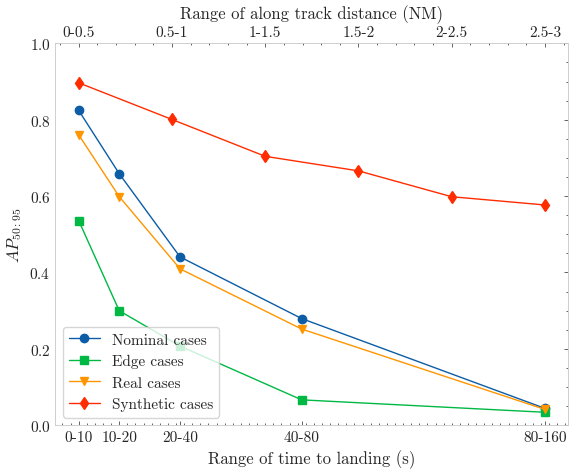

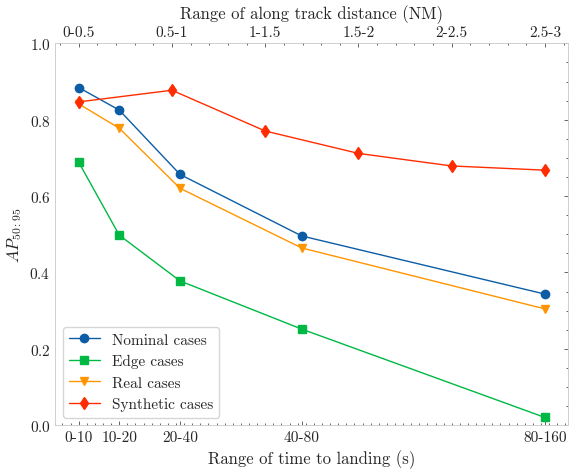

In [15]:
def plot_map_vs_dist(model_name, metrics_synth, metrics_nominal, metrics_edge, metrics_real):

    # 提取颜色序列
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    # 子图1
    fig, ax1 = plt.subplots(figsize=(6, 5), dpi=100)
    ln1_ = ax1.plot(bins_real_mid_points, metrics_nominal.iloc[0].values, 'o-', color=colors[0], label='Nominal cases')
    ln2_ = ax1.plot(bins_real_mid_points, metrics_edge.iloc[0].values, 's-', color=colors[1], label='Edge cases')
    ln3_ = ax1.plot(bins_real_mid_points, metrics_real.iloc[0].values, 'v-', color=colors[2], label='Real cases')
    ax1.set_xticks(bins_real_mid_points)
    ax1.set_xticklabels(metrics_nominal.columns.tolist())
    ax1.set_xlabel('Range of time to landing (s)')
    ax1.set_ylabel('$AP_{50:95}$')
    ax1.set_ylim(0, 1)
    ax1.grid(False)

    # 子图2
    ax2 = ax1.twiny()
    ln4_ = ax2.plot(metrics_synth.columns, metrics_synth.iloc[0].values, 'd-', color=colors[3], label='Synthetic cases')
    ax2.set_xlabel('Range of along track distance (NM)', labelpad=5)
    ax2.grid(False)

    # 联合legend
    lns = ln1_ + ln2_ + ln3_ + ln4_
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='lower left', frameon=True)

    model_name = model_name.split('/')[-1]
    plt.tight_layout()
    plt.savefig(
        f'{ROOT_PROJECT}/results/figs/paper/map_vs_distance_and_time_{model_name}.jpg',
        dpi=600, bbox_inches='tight')  # pad_inches=0.0
    plt.show()

plot_map_vs_dist(base_model_name, base_metrics_synth, base_metrics_nominal, base_metrics_edge, base_metrics_real)
plot_map_vs_dist(proposed_model_name,proposed_metrics_synth, proposed_metrics_nominal, proposed_metrics_edge, proposed_metrics_real)

In [16]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 搜索字体
font_name = "Times New Roman"
system_fonts = fm.findSystemFonts()
font_path = []
for f in system_fonts:
    try:
        if font_name in fm.FontProperties(fname=f).get_name():
            font_path.append(f)
    except Exception as e:
        print(f"跳过字体 {f}，因为发生了错误：{e}")

# 设置局部字体对象
if font_path:
    times_font = fm.FontProperties(fname=font_path[0], size=10)
    print(f'Times New Roman 字体已找到，使用字体{font_path[0]}。')
else:
    print('Times New Roman 字体未找到，使用默认字体。')

跳过字体 /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf，因为发生了错误：In FT2Font: Can not load face (unknown file format; error code 0x2)
Times New Roman 字体已找到，使用字体/usr/share/fonts/times.ttf。


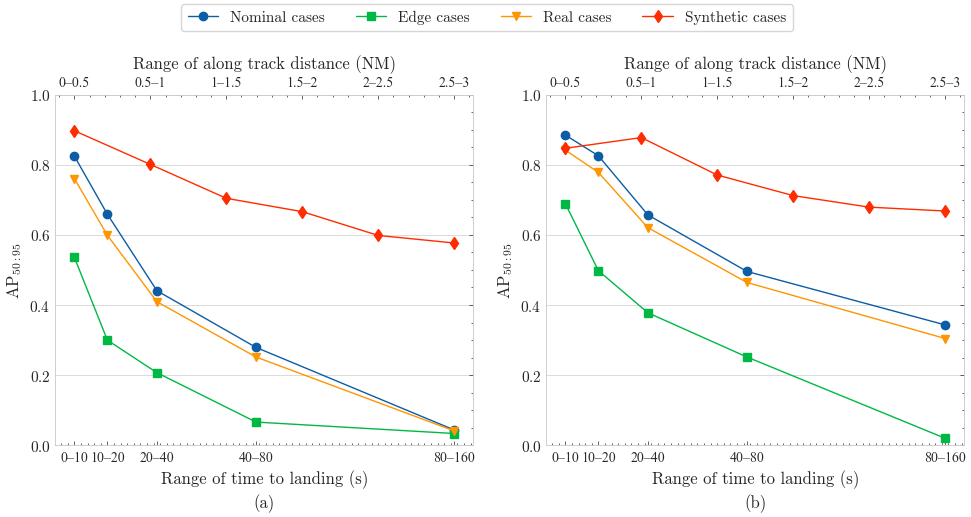

In [19]:
# 提取颜色序列
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# 子图1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)
# 合成数据
ln1_ = axes[0].plot(bins_real_mid_points, base_metrics_nominal.iloc[0].values, 'o-', color=colors[0], label='Nominal cases')
ln2_ = axes[0].plot(bins_real_mid_points, base_metrics_edge.iloc[0].values, 's-', color=colors[1], label='Edge cases')
ln3_ = axes[0].plot(bins_real_mid_points, base_metrics_real.iloc[0].values, 'v-', color=colors[2], label='Real cases')

axes[0].set_xticks(bins_real_mid_points)
labels = [label.replace('-', '\u2013') for label in base_metrics_nominal.columns.tolist()]
axes[0].set_xticklabels(labels, fontproperties=times_font)

axes[0].set_xlabel('Range of time to landing (s)')
axes[0].set_ylabel('AP$_{50:95}$')
axes[0].set_ylim(0, 1)
axes[0].set_title('(a)', y=-0.2)
axes[0].grid(axis='x')

# 真实数据
ax0 = axes[0].twiny()
labels = [label.replace('-', '\u2013') for label in base_metrics_synth.columns]  # 使用en dash
ln4_ = ax0.plot(labels, base_metrics_synth.iloc[0].values, 'd-', color=colors[3], label='Synthetic cases')
ax0.set_xticks(range(len(labels)))
ax0.set_xticklabels(labels, fontproperties=times_font)

ax0.set_xlabel('Range of along track distance (NM)', labelpad=5)
ax0.grid(axis='x')
# lns = ln1_ + ln2_ + ln3_ + ln4_
# labs = [l.get_label() for l in lns]
# axes[0].legend(lns, labs, loc='lower left', frameon=True)




# 子图2
# 合成数据
ln1_ = axes[1].plot(bins_real_mid_points, proposed_metrics_nominal.iloc[0].values, 'o-', color=colors[0], label='Nominal cases')
ln2_ = axes[1].plot(bins_real_mid_points, proposed_metrics_edge.iloc[0].values, 's-', color=colors[1], label='Edge cases')
ln3_ = axes[1].plot(bins_real_mid_points, proposed_metrics_real.iloc[0].values, 'v-', color=colors[2], label='Real cases')

axes[1].set_xticks(bins_real_mid_points)
labels = [label.replace('-', '\u2013') for label in proposed_metrics_nominal.columns.tolist()]  # 使用en dash
axes[1].set_xticklabels(labels, fontproperties=times_font)

axes[1].set_xlabel('Range of time to landing (s)')
axes[1].set_ylabel('AP$_{50:95}$')
axes[1].set_ylim(0, 1)
axes[1].set_title('(b)', y=-0.2)
axes[1].grid(axis='x')

# 真实数据
ax1 = axes[1].twiny()
labels = [label.replace('-', '\u2013') for label in proposed_metrics_synth.columns]
ln4_ = ax1.plot(labels, proposed_metrics_synth.iloc[0].values, 'd-', color=colors[3], label='Synthetic cases')
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, fontproperties=times_font)

ax1.set_xlabel('Range of along track distance (NM)', labelpad=5)
ax1.grid(axis='x')
lns = ln1_ + ln2_ + ln3_ + ln4_
labs = [l.get_label() for l in lns]

# 图例
fig.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=4, frameon=True)

plt.tight_layout()
plt.savefig(f'{ROOT_PROJECT}/results/figs/paper/map_vs_distance_and_time_proposed_vs_base_1.jpg', dpi=600, bbox_inches='tight')  # pad_inches=0.0
plt.savefig(f'{ROOT_PROJECT}/results/figs/paper/map_vs_distance_and_time_proposed_vs_base_1.svg', dpi=600, bbox_inches='tight')  # pad_inches=0.0
plt.show()

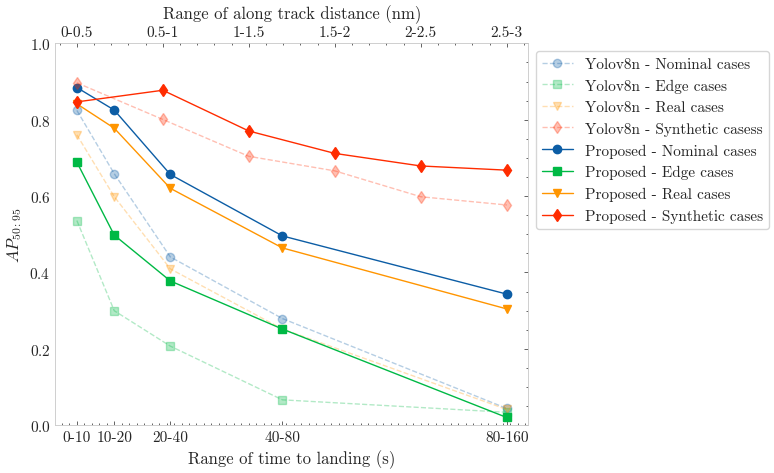

In [20]:
# 提取颜色序列
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# 子图1
fig, ax1 = plt.subplots(figsize=(8, 5), dpi=100)
ln1 = ax1.plot(bins_real_mid_points, base_metrics_nominal.iloc[0].values, 'o--', color=colors[0], alpha=0.3, label='Yolov8n - Nominal cases')
ln2 = ax1.plot(bins_real_mid_points, base_metrics_edge.iloc[0].values, 's--', color=colors[1], alpha=0.3, label='Yolov8n - Edge cases')
ln3 = ax1.plot(bins_real_mid_points, base_metrics_real.iloc[0].values, 'v--', color=colors[2], alpha=0.3, label='Yolov8n - Real cases')
ln1_ = ax1.plot(bins_real_mid_points, proposed_metrics_nominal.iloc[0].values, 'o-', color=colors[0], label='Proposed - Nominal cases')
ln2_ = ax1.plot(bins_real_mid_points, proposed_metrics_edge.iloc[0].values, 's-', color=colors[1], label='Proposed - Edge cases')
ln3_ = ax1.plot(bins_real_mid_points, proposed_metrics_real.iloc[0].values, 'v-', color=colors[2], label='Proposed - Real cases')
ax1.set_xticks(bins_real_mid_points)
ax1.set_xticklabels(proposed_metrics_nominal.columns.tolist())
ax1.set_xlabel('Range of time to landing (s)')
ax1.set_ylabel('$AP_{50:95}$')
ax1.set_ylim(0, 1)
ax1.grid(False)

# 子图2
ax2 = ax1.twiny()
ln4 = ax2.plot(proposed_metrics_synth.columns, base_metrics_synth.iloc[0].values, 'd--', color=colors[3], alpha=0.3, label='Yolov8n - Synthetic casess')
ln4_ = ax2.plot(proposed_metrics_synth.columns, proposed_metrics_synth.iloc[0].values, 'd-', color=colors[3], label='Proposed - Synthetic cases')
ax2.set_xlabel('Range of along track distance (nm)', labelpad=5)
ax2.grid(False)

# 联合legend
lns = ln1 + ln2 + ln3 + ln4 + ln1_ + ln2_ + ln3_ + ln4_
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left', frameon=True, bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig(
    f'{ROOT_PROJECT}/results/figs/paper/map_vs_distance_and_time_proposed_vs_base_2.jpg',
    dpi=600, bbox_inches='tight')  # pad_inches=0.0
plt.show()